In [0]:
from google.colab.drive import mount
mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
drive_path = 'drive/My Drive/'

In [0]:
!sudo apt-get install unar
!pip install pydicom

password = INbreast2012

In [0]:
!cp 'drive/My Drive/INbreast.rar' INbreast.rar
!unar 'INbreast.rar'

In [0]:
import os
import pydicom 
import numpy as np 
import matplotlib.pyplot as plt
import cv2
from random import shuffle
import glob
import csv
import pandas as pd

In [0]:
csv_path = 'INbreast/INbreast.xls'
df = pd.read_excel(csv_path)

filenames = df['File Name'].tolist()
labels   = df['Bi-Rads'].tolist()

data = dict(zip(filenames, labels))

In [0]:
def get_id_from_mask(path):
  return path[:-9]

def get_image_from_id(id):
  img_paths = glob.glob('INbreast/AllDICOMs/*.dcm')
  for img_path in img_paths:
    if id in img_path:
      return img_path
    
def get_array_from_dicom(path):
  img = pydicom.dcmread(path).pixel_array
  return img

def get_mammo_from_mask(msk_path):
  id = get_id_from_mask(msk_path)
  img_path  = get_image_from_id(id)
  img = get_array_from_dicom(img_path)
  return img_path, img
  
def map_label(fname):
  for f in data.keys():
    l = int(f) 
    if str(l) in fname:
      label = data[f]
      break
  if label in ['4a', '4b', '4c']:
    label = 4
  
  label = int(label)
  if label == 1:
    return 0 
  if label == 2 or label == 3:
    return 1
  else:
    return 2 
  
def resize_and_crop(img, mc_msk, mass_msk):
  mask = img == 0
  rows = np.flatnonzero((~mask).sum(axis=1))
  cols = np.flatnonzero((~mask).sum(axis=0))

  x0 = rows.min()
  x1 = rows.max()+1
  y0 = cols.min()
  y1 = cols.max()+1
  
  vs = [img, mc_msk, mass_msk]
  
  for i in range(3):
    v = vs[i]
    v = v[x0:x1, y0:y1]
    if v.max() > 0:
      v = v/v.max()
    vs[i] = cv2.resize(v, (IMG_SIZE, IMG_SIZE))
  
  return vs

def preprocess(X):
  X = np.stack((X,)*3, axis=-1)
  return X/X.max()

In [0]:
IMG_SIZE = 224
BATCH_SIZE = 16 

In [0]:
mass_msk_base = 'INbreast/extras/MassSegmentationMasks/'
mc_msk_base = 'INbreast/extras/CalcificationSegmentationMasks/'

msk_files = list(set(os.listdir(mass_msk_base)) | set(os.listdir(mc_msk_base)))

X = []
mc = []
ml = []
y = []

#
for msk_file  in msk_files:
  #get full mammogram 
  
  try:
    img_path, img = get_mammo_from_mask(msk_file)
  except:
    continue
  
  #check of MC view exists
  if msk_file in os.listdir(mc_msk_base):
    mc_msk = cv2.imread(mc_msk_base+msk_file)[...,0]
  else:
    mc_msk = np.zeros_like(img)

  #check if 
  if msk_file in os.listdir(mass_msk_base):
    mass_msk = cv2.imread(mass_msk_base+msk_file)[...,0]
  else:
    mass_msk = np.zeros_like(img) 

  label = map_label(img_path)
  
  if label == 0:
    continue
  else:
    label = label -1
  #get the mc mask 
  #print('Class = ', map_label(img_path))
  #plt.axis('off')
  #plt.imshow(np.concatenate([img/img.max(), mass_msk/255, mc_msk/255],axis = 1), cmap = 'gray')
  #plt.show()
    
  #img = crop_bg(img)
  #img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
  
  img, mc_msk, mass_msk =  resize_and_crop(img, mc_msk, mass_msk)
  print(mc_msk.shape)
  X.append(img)
  y.append(label)
  mc.append(mc_msk)
  ml.append(mass_msk)
  
  full = np.concatenate([img, mc_msk, mass_msk], axis = 1)
  plt.axis('off')
  plt.imshow(full, cmap = 'gray')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

0


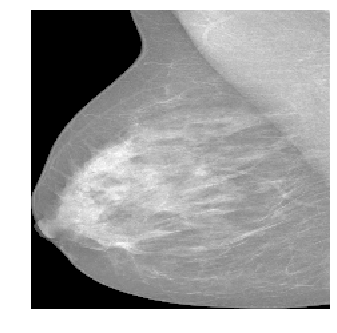

In [0]:
plt.axis('off')
print(y[0])
plt.imshow(X[0], cmap = 'gray')

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

steps_per_train = len(X_train)//BATCH_SIZE
steps_per_test  = len(X_test) //BATCH_SIZE

In [0]:
X_train = preprocess(X_train)
X_test  = preprocess(X_test )

In [0]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)


In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_batches = ImageDataGenerator().flow(X_train, y_train)
test_batches = ImageDataGenerator().flow(X_test, y_test)

train_crops = crop_generator(train_batches, 224)
test_crops = crop_generator(test_batches, 224)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
 Conv2D, MaxPooling2D, Input, Concatenate, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import keras.backend as K

In [0]:
def conv_block(fs, x):
  conv  = Conv2D(fs, (3, 3), padding = 'same', activation = 'relu')(x)
  pool  = MaxPooling2D(pool_size = (2, 2))(conv)
  return pool

def model1():
  inp = Input(shape = (IMG_SIZE, IMG_SIZE, 3))

  block1 = conv_block(64, inp)
  block2 = conv_block(128, block1)
  block3 = conv_block(128, block2)
  block4 = conv_block(128, block3)

  flatten = Flatten()(block4)

  dense = Dense(512, activation = 'relu')(flatten)
  out = Dense(1, activation = 'sigmoid')(dense)

  model = keras.models.Model(inputs = inp, outputs = out)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [0]:
model = model1()

In [0]:
model.fit_generator(train_crops, steps_per_epoch = steps_per_train, epochs=10, verbose=1, 
                      validation_data = test_crops, validation_steps = steps_per_test)

Epoch 1/10
19/19 [==============================] - 6s 291ms/step - loss: 0.6982 - acc: 0.6742 - val_loss: 0.5994 - val_acc: 0.7429
Epoch 2/10
19/19 [==============================] - 4s 215ms/step - loss: 0.6073 - acc: 0.7096 - val_loss: 0.5796 - val_acc: 0.7429
Epoch 3/10
19/19 [==============================] - 4s 213ms/step - loss: 0.5887 - acc: 0.7108 - val_loss: 0.5338 - val_acc: 0.7429
Epoch 4/10
19/19 [==============================] - 4s 214ms/step - loss: 0.6007 - acc: 0.6961 - val_loss: 0.5087 - val_acc: 0.7429
Epoch 5/10
19/19 [==============================] - 4s 213ms/step - loss: 0.5598 - acc: 0.7261 - val_loss: 0.4965 - val_acc: 0.7714
Epoch 6/10
19/19 [==============================] - 4s 214ms/step - loss: 0.5148 - acc: 0.7432 - val_loss: 0.4896 - val_acc: 0.7714
Epoch 7/10
19/19 [==============================] - 4s 209ms/step - loss: 0.4538 - acc: 0.7931 - val_loss: 0.4655 - val_acc: 0.8571
Epoch 8/10
19/19 [==============================] - 4s 213ms/step - loss: 0.

In [0]:
pred = model.predict(X_test)
pred[pred > 0.5] = 1 
pred[pred <= 0.5] = 0
ypred = pred.squeeze()
print(ypred.astype('int32'))
print(np.array(y_test))

[0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1]
[0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1]


In [0]:
def fine_tune():
  #download and load the pretrained model
  vgg = keras.applications.VGG16(input_shape = (IMG_SIZE, IMG_SIZE, 3), weights ='imagenet', include_top = False)

  #freeze all the layers as a fixed feature extractor
  for layer in vgg.layers:
    layer.trainable = False

  flatten = GlobalAveragePooling2D()(vgg.output)

  #first branch for classification
  branch1 = Dense(256, activation = 'relu')(flatten)
  out = Dense(1, activation = 'sigmoid')(branch1)

  #create a model with one input and two outputs 
  model = keras.models.Model(inputs = vgg.input , outputs = out)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [0]:
model = fine_tune()

In [0]:
model.fit_generator(train_crops, steps_per_epoch = steps_per_train, epochs=10, verbose=1, 
                      validation_data = test_crops, validation_steps = steps_per_test)

Epoch 1/10
19/19 [==============================] - 8s 413ms/step - loss: 0.6383 - acc: 0.6619 - val_loss: 0.5738 - val_acc: 0.7429
Epoch 2/10
19/19 [==============================] - 6s 320ms/step - loss: 0.6003 - acc: 0.7097 - val_loss: 0.5683 - val_acc: 0.7429
Epoch 3/10
19/19 [==============================] - 6s 321ms/step - loss: 0.5957 - acc: 0.7063 - val_loss: 0.5653 - val_acc: 0.7429
Epoch 4/10
19/19 [==============================] - 6s 318ms/step - loss: 0.5923 - acc: 0.7064 - val_loss: 0.5704 - val_acc: 0.7429
Epoch 5/10
19/19 [==============================] - 6s 325ms/step - loss: 0.5962 - acc: 0.7043 - val_loss: 0.6009 - val_acc: 0.7429
Epoch 6/10
19/19 [==============================] - 6s 321ms/step - loss: 0.5932 - acc: 0.7092 - val_loss: 0.5584 - val_acc: 0.7429
Epoch 7/10
19/19 [==============================] - 6s 318ms/step - loss: 0.5950 - acc: 0.6933 - val_loss: 0.5634 - val_acc: 0.7429
Epoch 8/10
19/19 [==============================] - 6s 320ms/step - loss: 0.